### Model development based on demographic features and xgboost architecture

*Date:* 2025-06-19 <br> 
*Author:* salil apte  <br> 
*Version:* 1.0  <br> 
*Filename:* `03-demo-xgboost-model.ipynb`

This notebook contains the training and evaluation of a [xgboost](https://xgboost.readthedocs.io) model using only the additional five (likely demographic) features. The process is repeated 50 times with different training/validation splits, which are designed to not have any overlap of users.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [4]:
# Load the training data
df = pd.read_parquet(r"E:\repos\vital-sign-estimation\data\processed\demographics.parquet")
labels = pd.read_csv(r"E:\repos\vital-sign-estimation\data\raw\train_labels.csv")
print(df.shape)
df.head()

(60000, 6)


,features_0,features_1,features_2,features_3,features_4,id
0,-1.251488,1.009981,0.603974,0.252646,1.949994,000
1,0.087479,1.475090,0.033434,0.252646,0.715404,001
2,-0.715901,1.087499,0.603974,0.252646,1.209240,002
3,1.069389,0.002245,-1.250281,0.252646,-0.272268,003
4,-0.626637,0.932463,1.174513,0.252646,0.550792,004


In [5]:
# Step 1: Prepare features, target, and group labels
feature_names = ["features_0", "features_1", "features_2", "features_3", "features_4"]
X = df[feature_names].to_numpy()
y = labels.to_numpy()
unique_ids = df["id"].unique()

In [6]:
# Set the training parameters
n_bootstraps = 50
test_size = 0.2
seed = 1

In [7]:
# Prepare arrays to store results
mse_list = []
mape_list = []

for i in range(n_bootstraps):

    # Split the ids for training and testing    
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=i)

    train_mask = df["id"].isin(train_ids)
    test_mask = df["id"].isin(test_ids)

    # Split the train and test dataset
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[test_mask], y[test_mask]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dval = xgb.DMatrix(data=X_val, label=y_val)

    # Set training parameters
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": 3,
        "eta": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 1.0,
        "reg_lambda": 1.0,
        "seed": seed
    }

    # Train model with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        evals=evals,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict and evaluate
    y_pred = model.predict(dval)
    mse = mean_squared_error(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    print(f"XGBoost MSE: {mse:.2f}")
    print(f"XGBoost MAPE: {mape:.2f}")

    mse_list.append(mse)
    mape_list.append(mape)

XGBoost MSE: 17.89
XGBoost MAPE: 2.89
XGBoost MSE: 17.74
XGBoost MAPE: 3.12
XGBoost MSE: 19.94
XGBoost MAPE: 3.53
XGBoost MSE: 17.74
XGBoost MAPE: 3.18
XGBoost MSE: 17.87
XGBoost MAPE: 3.32
XGBoost MSE: 18.27
XGBoost MAPE: 3.65
XGBoost MSE: 17.41
XGBoost MAPE: 3.51
XGBoost MSE: 17.49
XGBoost MAPE: 3.09
XGBoost MSE: 18.30
XGBoost MAPE: 3.47
XGBoost MSE: 18.07
XGBoost MAPE: 5.09
XGBoost MSE: 19.55
XGBoost MAPE: 3.20
XGBoost MSE: 19.29
XGBoost MAPE: 2.73
XGBoost MSE: 19.61
XGBoost MAPE: 3.73
XGBoost MSE: 18.18
XGBoost MAPE: 4.03
XGBoost MSE: 18.39
XGBoost MAPE: 3.78
XGBoost MSE: 17.60
XGBoost MAPE: 3.22
XGBoost MSE: 18.05
XGBoost MAPE: 4.21
XGBoost MSE: 17.35
XGBoost MAPE: 3.51
XGBoost MSE: 17.31
XGBoost MAPE: 2.98
XGBoost MSE: 18.07
XGBoost MAPE: 4.94
XGBoost MSE: 18.68
XGBoost MAPE: 3.33
XGBoost MSE: 17.02
XGBoost MAPE: 2.97
XGBoost MSE: 20.04
XGBoost MAPE: 4.69
XGBoost MSE: 17.63
XGBoost MAPE: 2.62
XGBoost MSE: 17.98
XGBoost MAPE: 2.82
XGBoost MSE: 17.35
XGBoost MAPE: 3.86
XGBoost MSE:

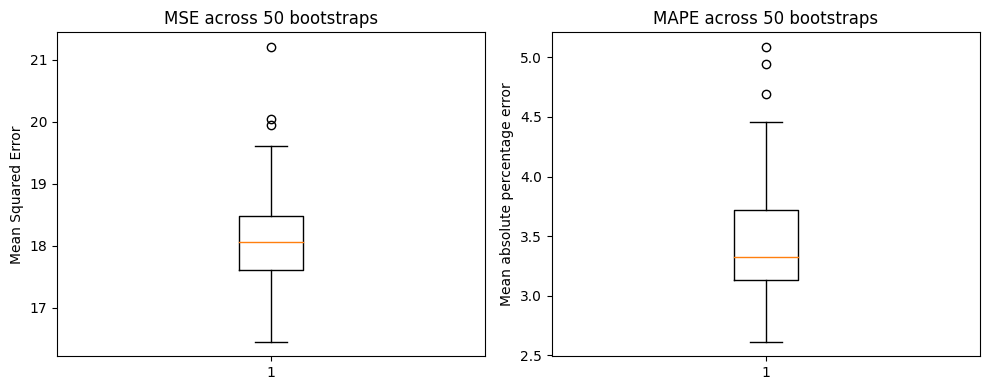

In [8]:
# Plot boxplots for MSE and MAPE across 50 repetitions
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(mse_list)
plt.title("MSE across 50 bootstraps")
plt.ylabel("Mean Squared Error")

plt.subplot(1, 2, 2)
plt.boxplot(mape_list)
plt.title("MAPE across 50 bootstraps")
plt.ylabel("Mean absolute percentage error")

plt.tight_layout()
plt.show()

In [ ]:
# Export results to csv for plotting
dict_results = {"MSE-DMG": mse_list, "MAPE-DMG": mape_list}
pd.DataFrame(dict_results).to_csv(r"E:\repos\vital-sign-estimation\reports\results\dmg_only.csv", index=False)